# 젠더 법안 K-means

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [3]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [4]:
gender = pd.read_csv('./17th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
# gender = gender.drop('level_0',1)
print(gender.shape)

(423, 10)


In [5]:
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,178363,여성발전기본법 일부개정법률안,2008-05-21,위원장,2008-05-22,원안가결,제17대 (2004~2008) 제273회,가. 2006년 4월 13일 김기현의원이 대표발의한 여성발전기본법 일부개정법률...,여성가족위원회,[]
1,178362,성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안,2008-05-21,위원장,2008-05-22,원안가결,제17대 (2004~2008) 제273회,가. 2005년 6월 18일 제254회국회(임시회) 제1차 여성위원회에서 20...,여성가족위원회,[]
2,178361,성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,2008-05-21,위원장,2008-05-22,원안가결,제17대 (2004~2008) 제273회,가. 2008년 5월 8일 정부가 발의한 발의한 성폭력범죄의처벌및피해자보호등에...,법제사법위원회,[]
3,178351,성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,2008-05-15,의원,2008-05-22,대안반영폐기,제17대 (2004~2008) 제273회,최근 미성년자 대상 성폭행 범죄로 집행유예를 받은 전력이 있는 자가 다시 초등...,법제사법위원회,"['이종걸', '류근찬', '변재일', '서혜석', '양승조', '염동연', '유승..."
4,178350,성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,2008-05-14,의원,2008-05-22,대안반영폐기,제17대 (2004~2008) 제273회,■ 최근 미성년자 대상 성폭행으로 집행유예의 전력이 있는 자가 다시 이웃에 사...,법제사법위원회,"['최인기', '강기정', '김재윤', '김효석', '문학진', '선병렬', '우제..."


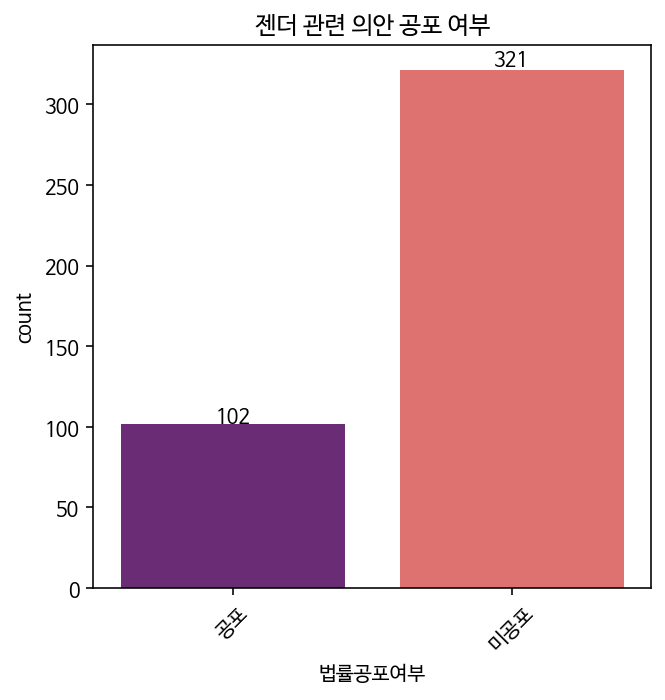

In [6]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [4]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [5]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [6]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 44.2 ms, sys: 2.39 ms, total: 46.6 ms
Wall time: 46.1 ms


In [7]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [8]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 38.8 s, sys: 707 ms, total: 39.5 s
Wall time: 26.8 s


0    [여성발전기본법, 일부개정법률안, 김기현의원, 대표발의, 여성발전기본법, 일부개정법...
1    [성매매방지, 피해자보호, 법률, 일부개정법률안, 회국회, 임시회, 여성위원회, 유...
2    [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 정부, 발의, 발의, 성폭...
Name: tokens, dtype: object

In [9]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 152 ms, sys: 4.1 ms, total: 156 ms
Wall time: 166 ms


In [10]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.43 ms, sys: 40 µs, total: 1.47 ms
Wall time: 1.61 ms


In [11]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(422, 13)


In [12]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [13]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-26 23:57:03,478 : INFO : collecting all words and their counts
2020-09-26 23:57:03,480 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-26 23:57:03,498 : INFO : collected 8587 word types from a corpus of 56820 raw words and 422 sentences
2020-09-26 23:57:03,507 : INFO : Loading a fresh vocabulary
2020-09-26 23:57:03,530 : INFO : effective_min_count=10 retains 1095 unique words (12% of original 8587, drops 7492)
2020-09-26 23:57:03,531 : INFO : effective_min_count=10 leaves 39510 word corpus (69% of original 56820, drops 17310)
2020-09-26 23:57:03,538 : INFO : deleting the raw counts dictionary of 8587 items
2020-09-26 23:57:03,540 : INFO : sample=0.001 downsamples 66 most-common words
2020-09-26 23:57:03,542 : INFO : downsampling leaves estimated 34698 word corpus (87.8% of prior 39510)
2020-09-26 23:57:03,548 : INFO : estimated required memory for 1095 words and 100 dimensions: 1423500 bytes
2020-09-26 23:57:03,549 : INFO : resetting layer wei

2020-09-26 23:57:04,723 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:04,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:04,729 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:04,731 : INFO : EPOCH - 15 : training on 56820 raw words (34607 effective words) took 0.0s, 829382 effective words/s
2020-09-26 23:57:04,767 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:04,770 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:04,772 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:04,775 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:04,778 : INFO : EPOCH - 16 : training on 56820 raw words (34720 effective words) took 0.0s, 816952 effective words/s
2020-09-26 23:57:04,809 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-09-26 23:57:05,455 : INFO : EPOCH - 31 : training on 56820 raw words (34751 effective words) took 0.0s, 788296 effective words/s
2020-09-26 23:57:05,486 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:05,488 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:05,491 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:05,493 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:05,494 : INFO : EPOCH - 32 : training on 56820 raw words (34747 effective words) took 0.0s, 953469 effective words/s
2020-09-26 23:57:05,532 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:05,535 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:05,542 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:05,543 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

2020-09-26 23:57:06,216 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:06,219 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:06,220 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:06,221 : INFO : EPOCH - 48 : training on 56820 raw words (34660 effective words) took 0.0s, 967330 effective words/s
2020-09-26 23:57:06,257 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:06,260 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:06,263 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:06,265 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:06,267 : INFO : EPOCH - 49 : training on 56820 raw words (34743 effective words) took 0.0s, 841174 effective words/s
2020-09-26 23:57:06,305 : INFO : worker thread finished; awaiting finish of 3 more threads
2020

2020-09-26 23:57:06,939 : INFO : EPOCH - 64 : training on 56820 raw words (34653 effective words) took 0.0s, 953514 effective words/s
2020-09-26 23:57:06,970 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:06,971 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:06,976 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:06,977 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:06,978 : INFO : EPOCH - 65 : training on 56820 raw words (34801 effective words) took 0.0s, 1106969 effective words/s
2020-09-26 23:57:07,011 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:07,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:07,014 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:07,018 : INFO : worker thread finished; awaiting finish of 0 more threads
202

2020-09-26 23:57:07,667 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:07,668 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:07,670 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:07,671 : INFO : EPOCH - 81 : training on 56820 raw words (34754 effective words) took 0.0s, 1089161 effective words/s
2020-09-26 23:57:07,705 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:07,707 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:07,711 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:07,712 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:07,714 : INFO : EPOCH - 82 : training on 56820 raw words (34683 effective words) took 0.0s, 892869 effective words/s
2020-09-26 23:57:07,760 : INFO : worker thread finished; awaiting finish of 3 more threads
202

2020-09-26 23:57:08,444 : INFO : EPOCH - 97 : training on 56820 raw words (34685 effective words) took 0.0s, 812102 effective words/s
2020-09-26 23:57:08,477 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:08,479 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:08,485 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:08,487 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:57:08,488 : INFO : EPOCH - 98 : training on 56820 raw words (34779 effective words) took 0.0s, 898106 effective words/s
2020-09-26 23:57:08,523 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:57:08,528 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:57:08,529 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:57:08,534 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [14]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [15]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [16]:
len(gender['문장벡터'][0])

100

In [17]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-26 23:57:08,773 : INFO : precomputing L2-norms of word weight vectors


[('사회참여', 0.4839130640029907), ('남성', 0.4539113938808441), ('모성보호', 0.4209933876991272), ('실정', 0.40388357639312744), ('여성근로자', 0.3983326554298401), ('보장하', 0.3946588635444641), ('휴가', 0.3828338384628296), ('고령자', 0.3794366121292114), ('가정생활', 0.371778666973114), ('동일', 0.34983426332473755)]
[('성범죄자', 0.5021790266036987), ('신상정보', 0.49856022000312805), ('성범죄', 0.46887776255607605), ('강제추행', 0.4546217918395996), ('노출', 0.4123428463935852), ('업소', 0.40972936153411865), ('성보호', 0.4055270552635193), ('범죄', 0.401073157787323), ('청소년들', 0.3903230130672455), ('강간', 0.3808721601963043)]


In [19]:
# model.wv.vocab.items()

## t-SNE 시각화

In [18]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 422 samples in 0.002s...
[t-SNE] Computed neighbors for 422 samples in 0.325s...
[t-SNE] Computed conditional probabilities for sample 422 / 422
[t-SNE] Mean sigma: 2.490631
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.161186
[t-SNE] KL divergence after 300 iterations: 0.886218


In [19]:
tsne_df.head()

,x,y
의안명,,
여성발전기본법 일부개정법률안,6.037667,-2.785692
성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안,8.956128,-4.017220
성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,10.239714,10.277892
성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,10.850548,12.274778
성폭력범죄의 처벌 및 피해자보호 등에 관한 법률 일부개정법률안,10.817779,12.381425


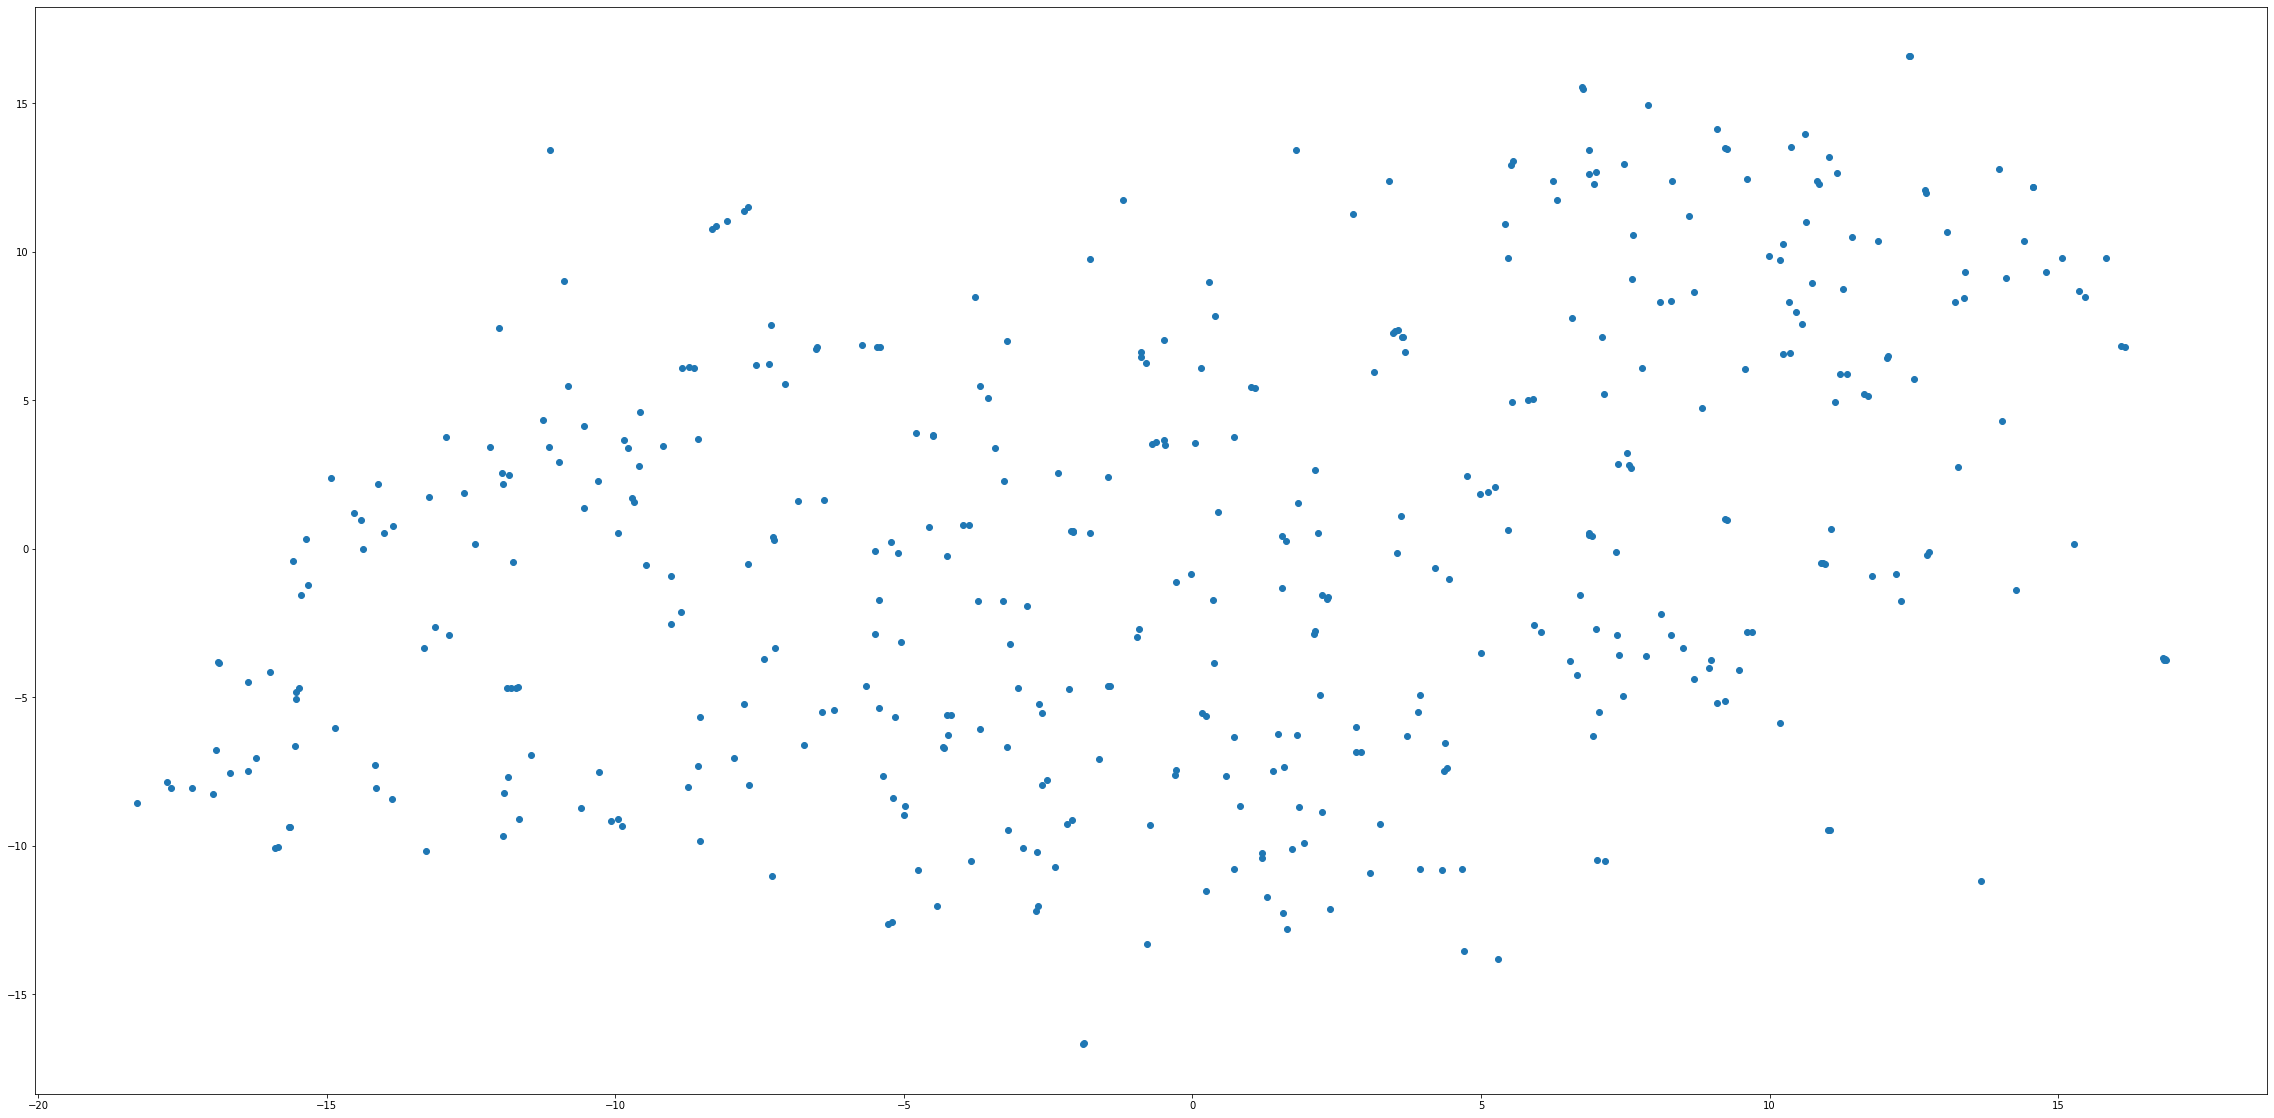

In [20]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:01<00:00, 12.17it/s]


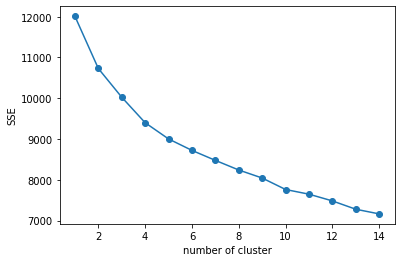

In [21]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [22]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

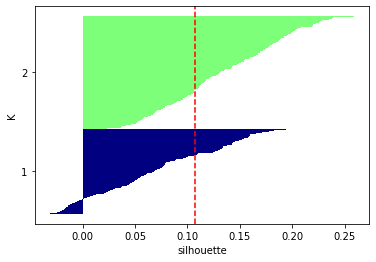

In [23]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

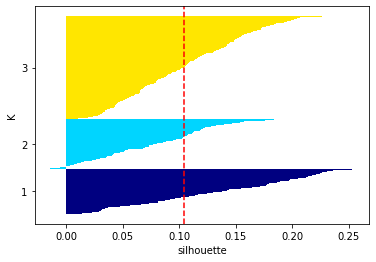

In [24]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

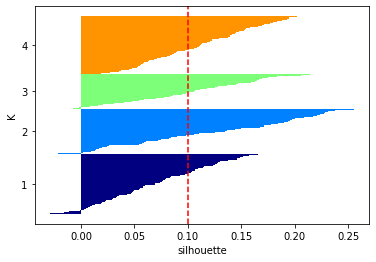

In [25]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

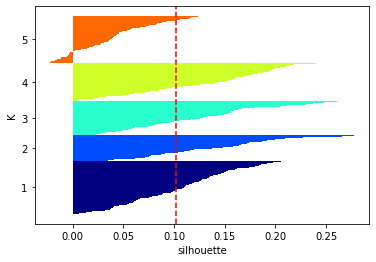

In [26]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

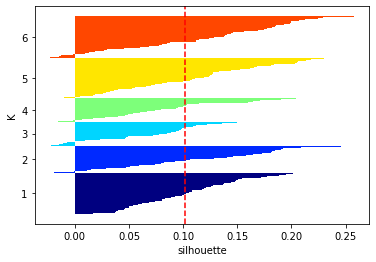

In [27]:
word_vectors = gender['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [28]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [29]:
gender['category'].value_counts()

0    127
2    123
3     95
1     77
Name: category, dtype: int64

In [30]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [31]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [32]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [33]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [34]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-26 23:57:44,126 : INFO : Generating new fontManager, this may take some time...
2020-09-26 23:57:45,034 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-26 23:57:45,340 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2020-09-26 23:57:45,436 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)


In [36]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
gender_g5 = gender[gender['category'] == 4]
# gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [37]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
gender_g5_tokens = total_tokens(gender_g5['tokens'])
# gender_g6_tokens = total_tokens(gender_g6['tokens'])

In [54]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고', '대안','대표발의','국회','문장','신설','위원회','국민','임시회','법률안','회부',
            '규정']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
# gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]

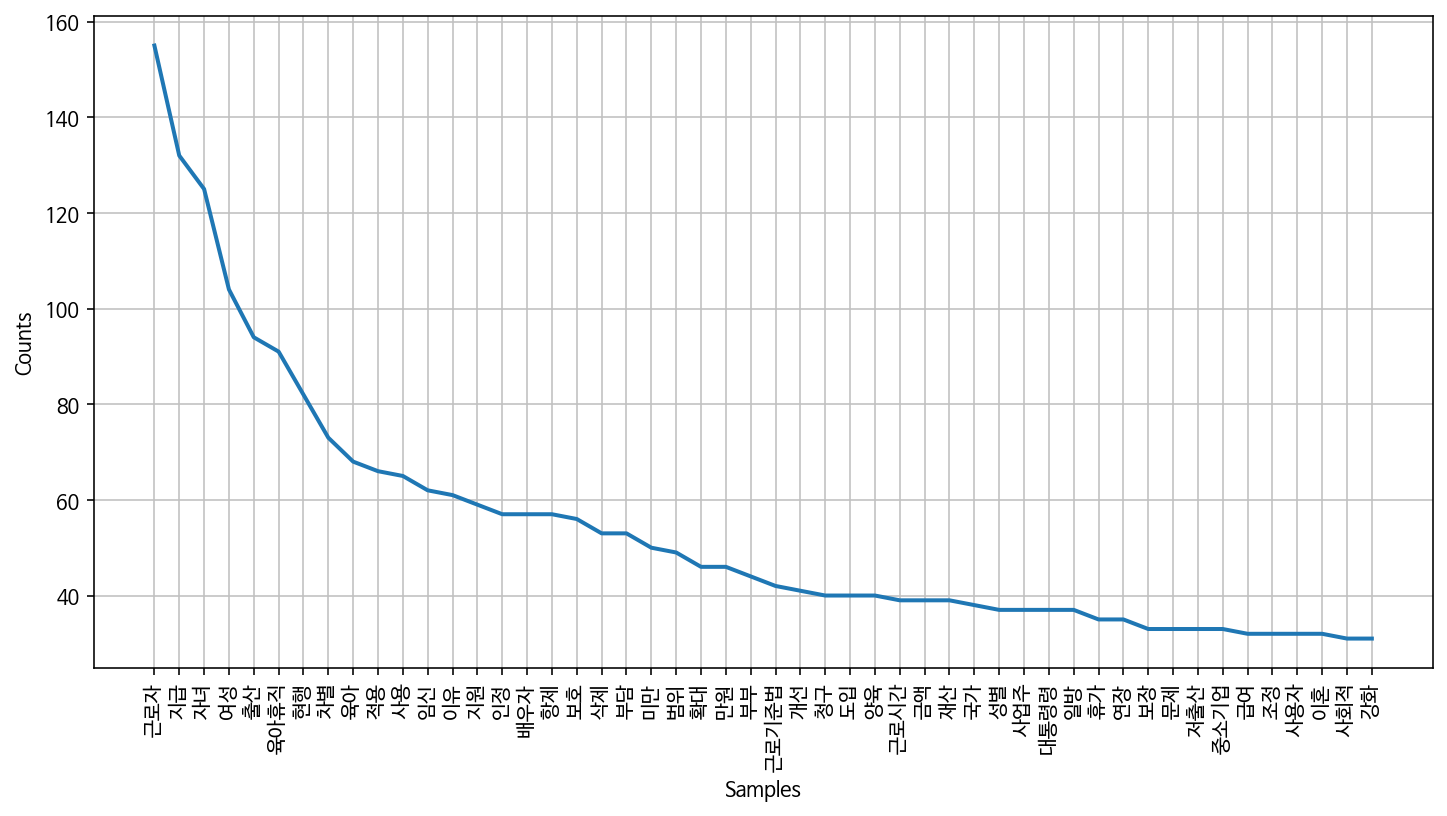

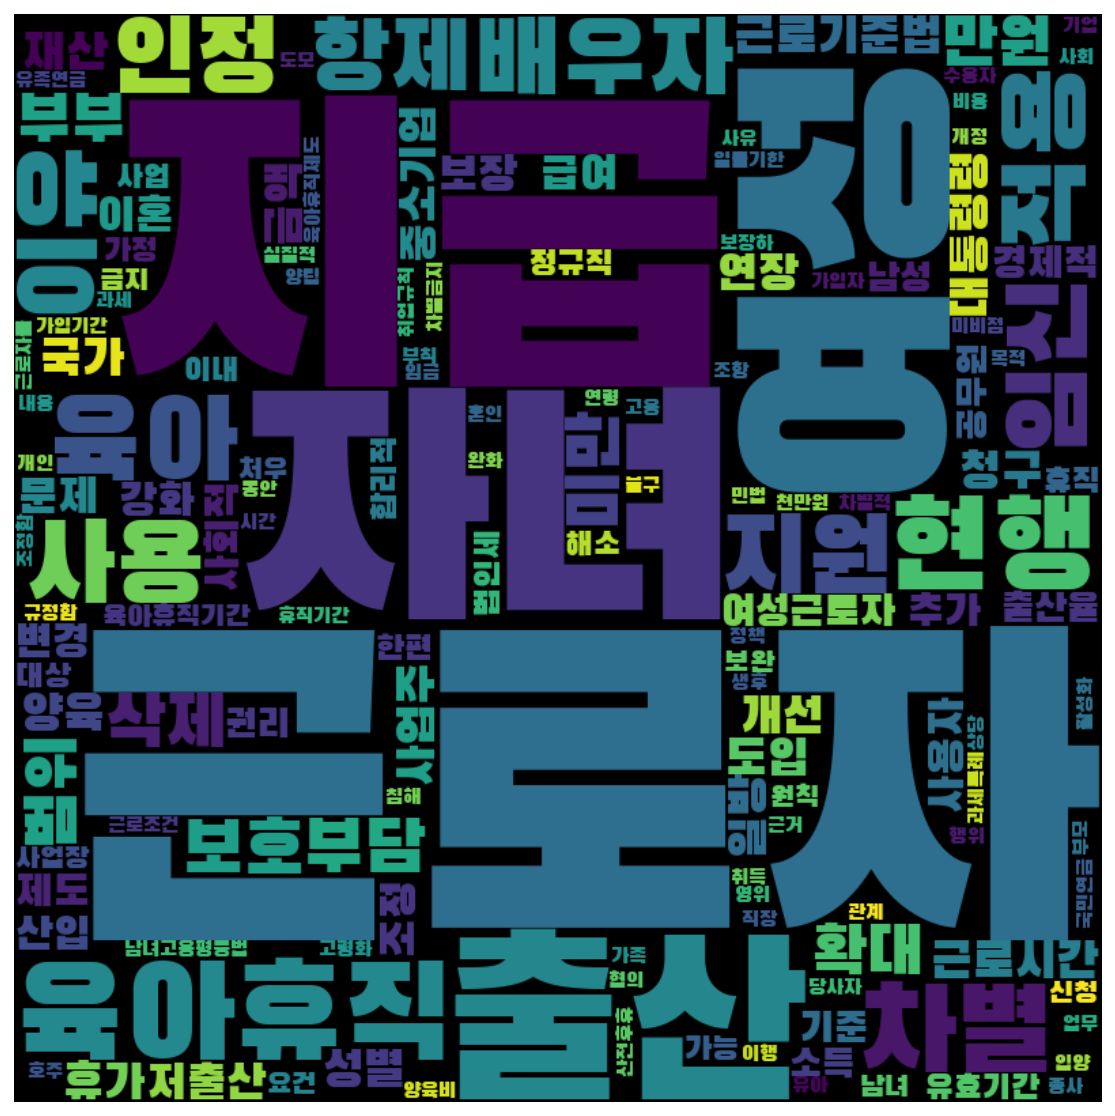

In [55]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

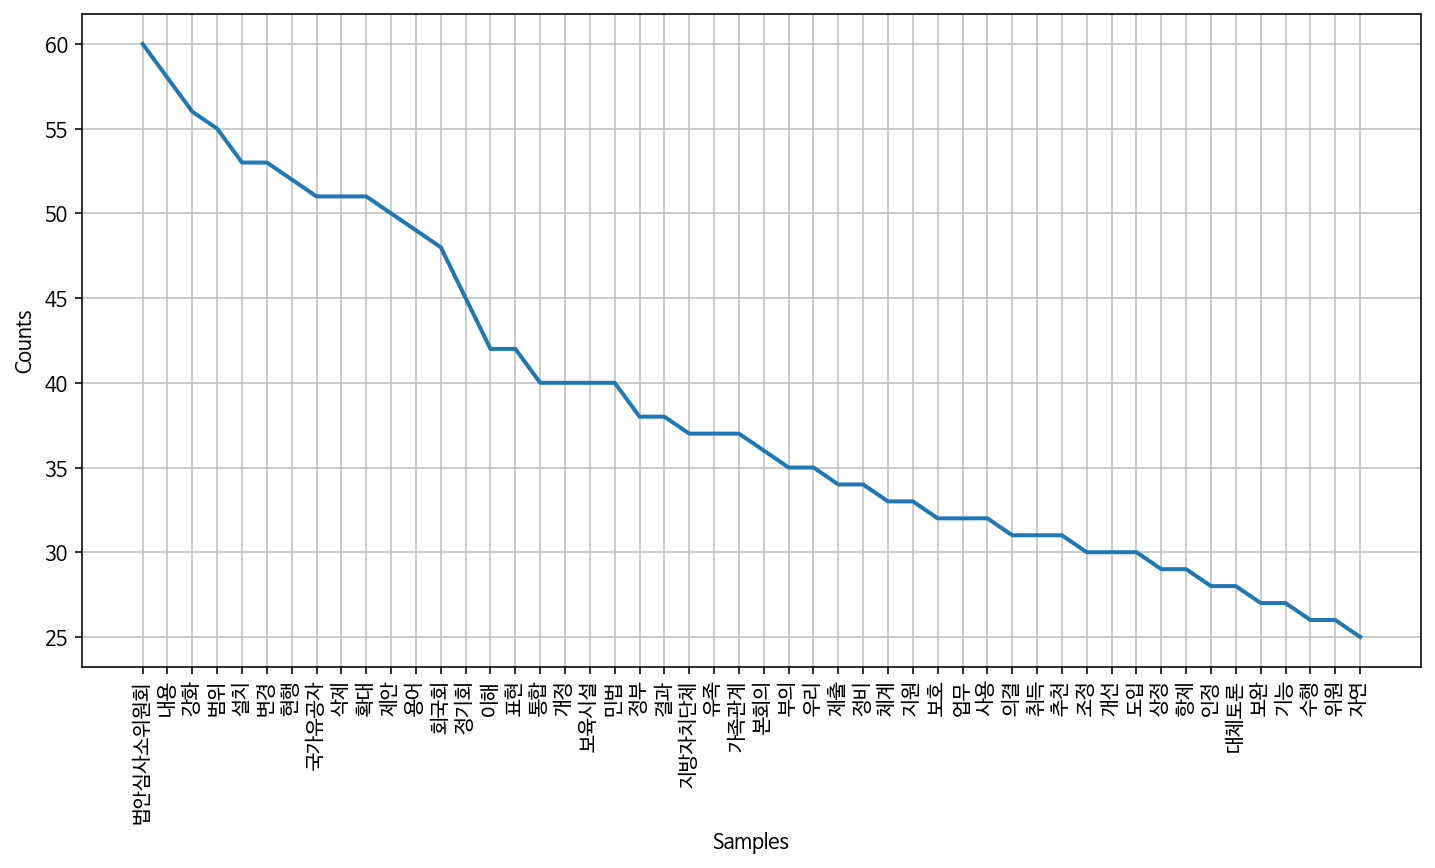

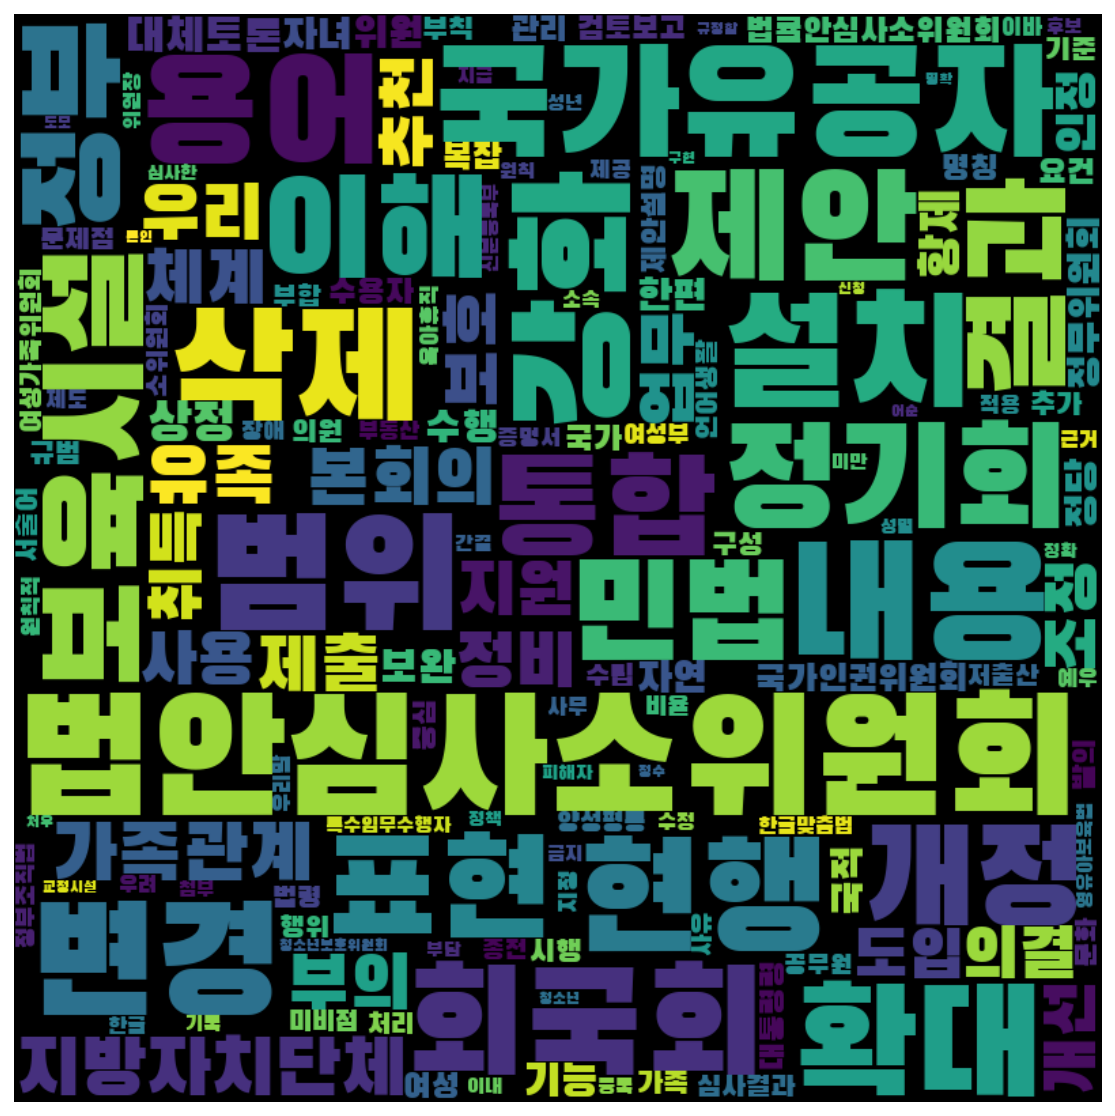

In [56]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

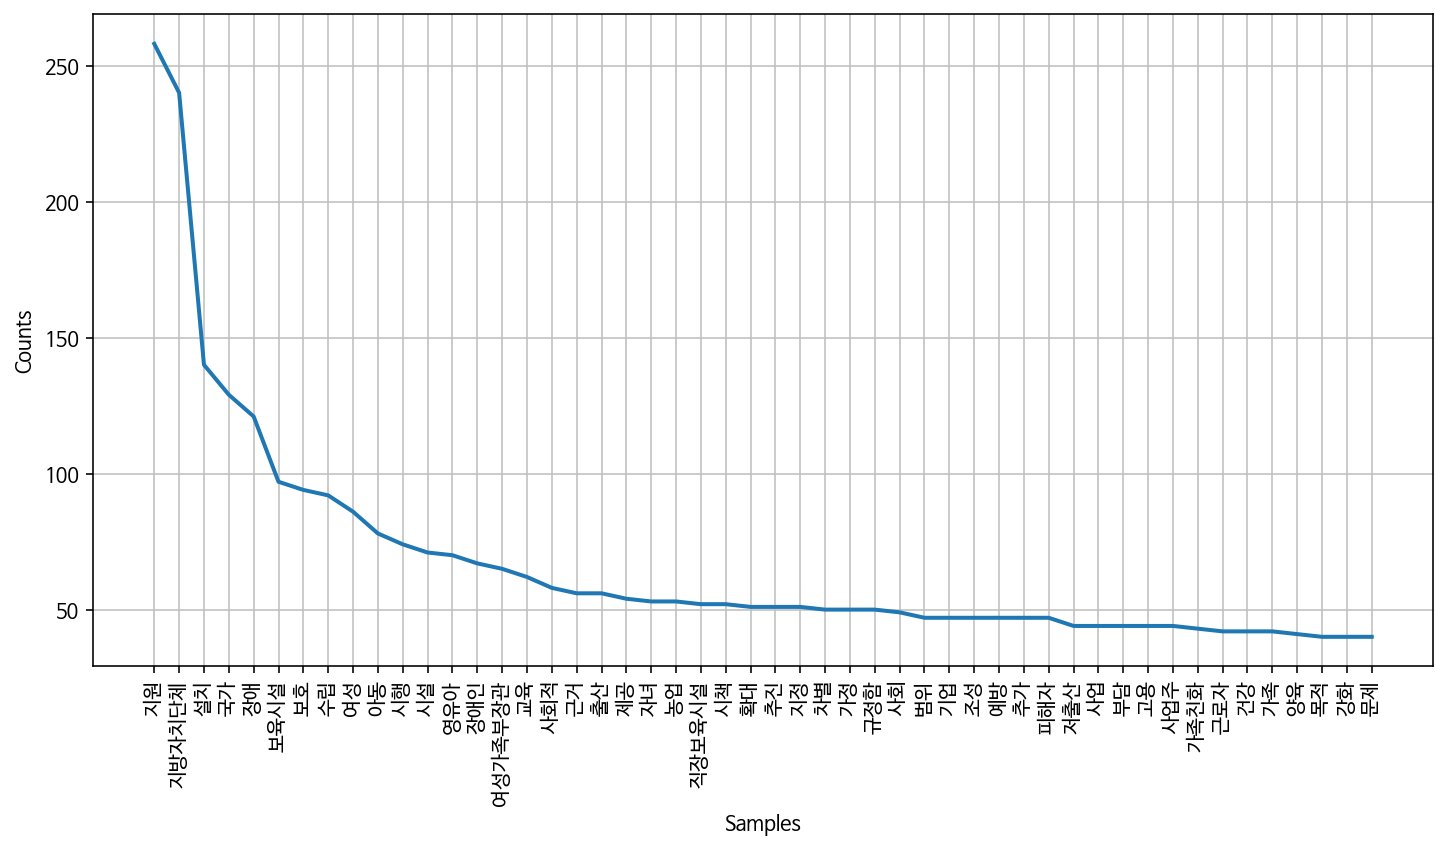

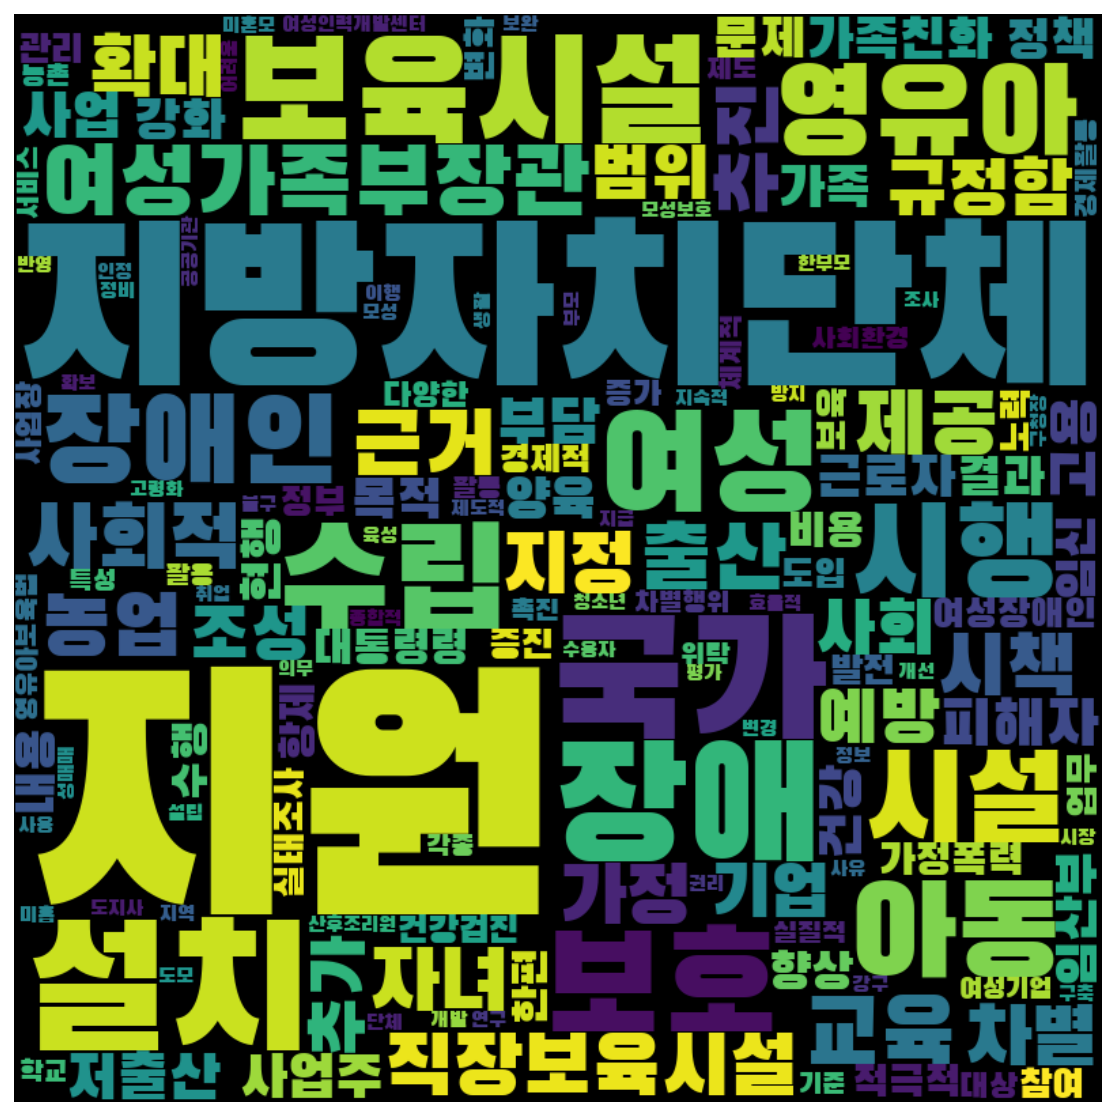

In [57]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

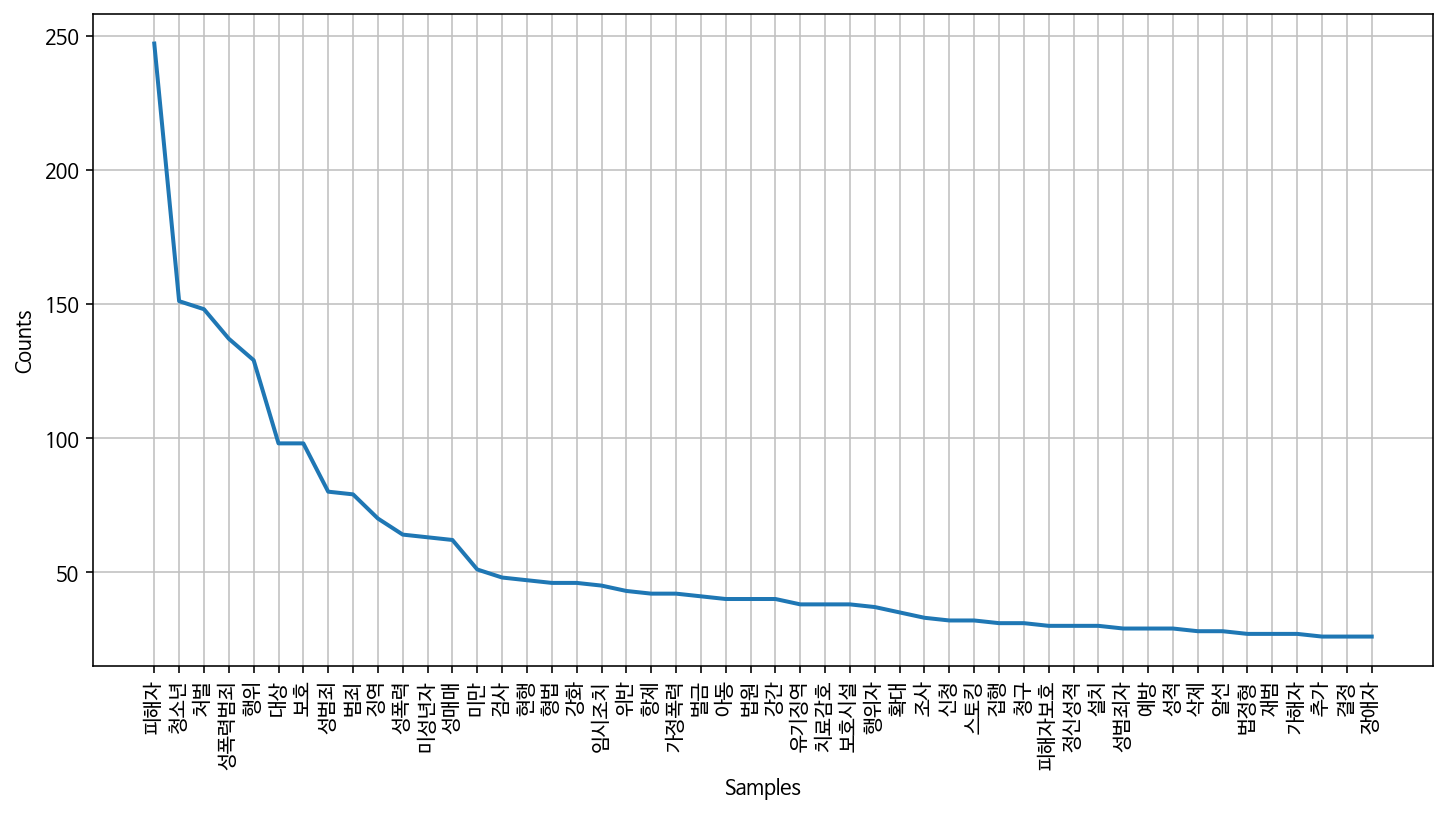

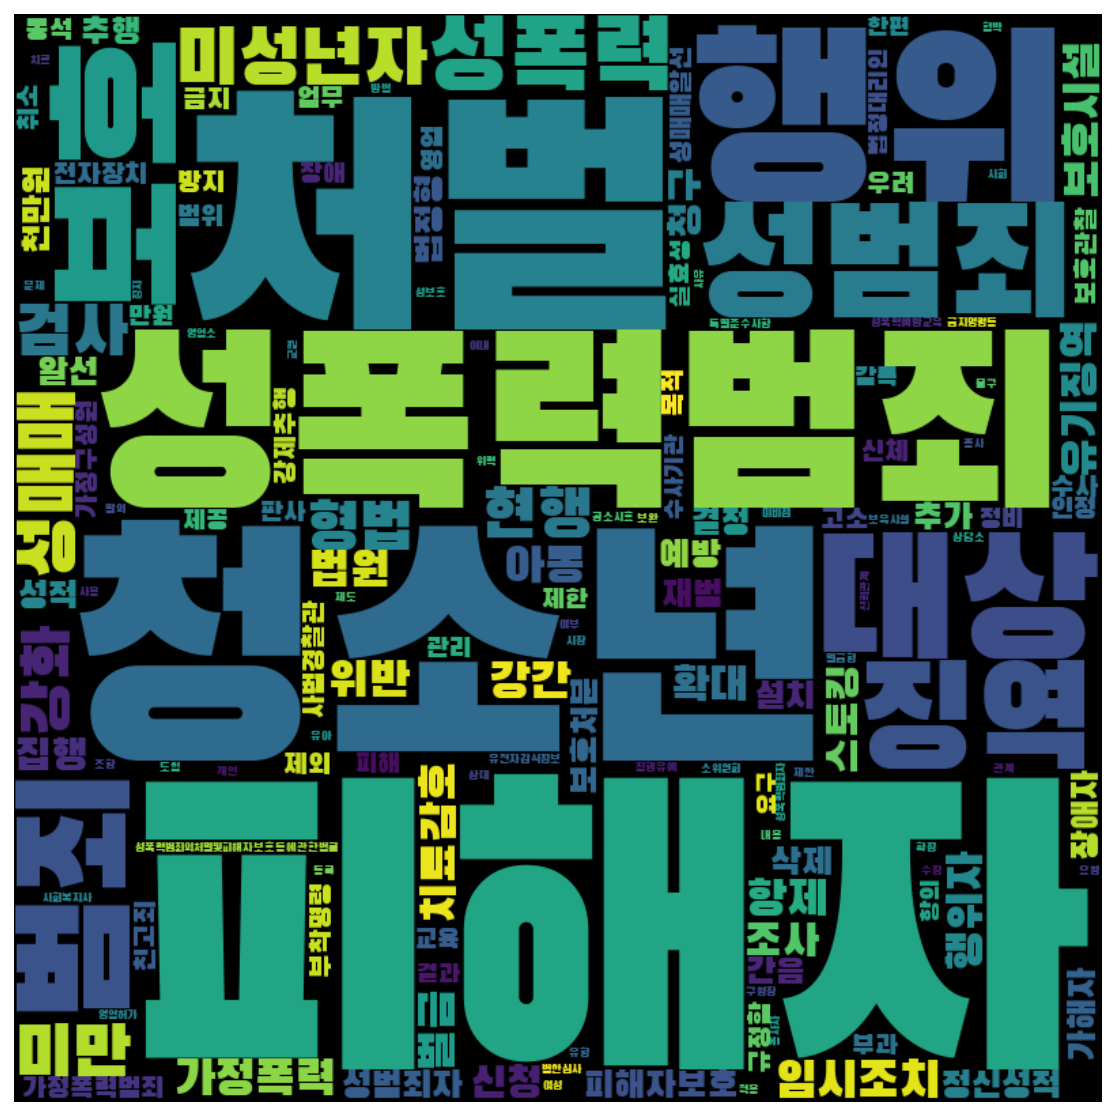

In [58]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


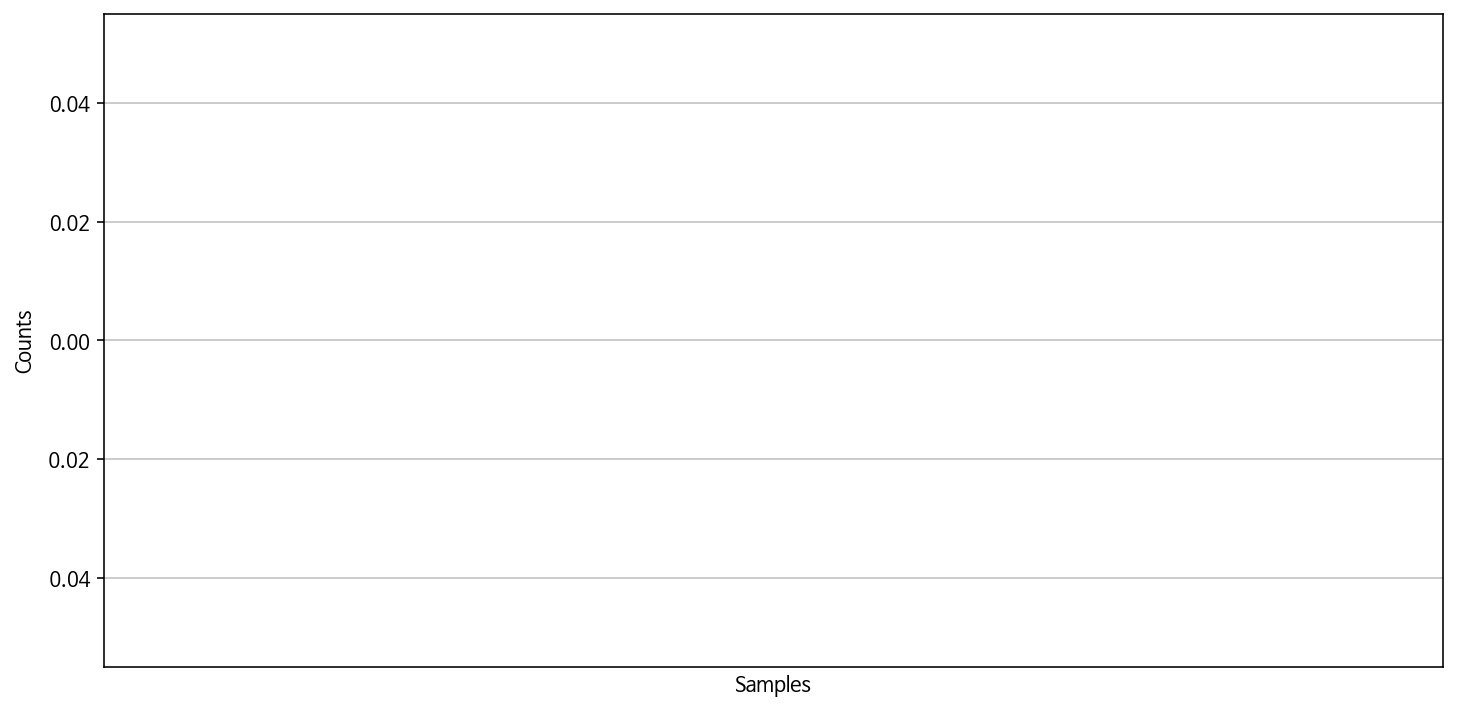

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [43]:
frewords_vis(gender_g5_tokens)
wordcloud_vis(gender_g5_tokens)

In [70]:
# frewords_vis(gender_g6_tokens)
# wordcloud_vis(gender_g6_tokens)